<a href="https://colab.research.google.com/github/emrehangorgec/GANsNFTs/blob/main/Generative_Art_NFTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install openai

In [ ]:
!pip install ninja

In [ ]:
!pip install ipywidgets

In [ ]:
!pip install requests

In [ ]:
!pip install pinata

# API Configurations


In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'sk-proj-nnC3biEGepCwamKhhcvrT3BlbkFJ1PEaIxRxadXO0PbHLXM0'

In [ ]:
print("API Key Set:", os.environ["OPENAI_API_KEY"])

API Key Set: sk-proj-nnC3biEGepCwamKhhcvrT3BlbkFJ1PEaIxRxadXO0PbHLXM0


In [ ]:
!pip show openai

Name: openai
Version: 1.30.5
Summary: The official Python library for the openai API
Home-page: 
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: anyio, distro, httpx, pydantic, sniffio, tqdm, typing-extensions
Required-by: 


In [ ]:
# Check if 'OPENAI_API_KEY' exists
is_api_key_set = 'OPENAI_API_KEY' in os.environ
print("Is the API key set?", is_api_key_set)

Is the API key set? True


In [6]:
pinata = Pinata(api_key=userdata.get('pinata-api-key'),
                secret_key=userdata.get('pinata-secret-key'),
                access_token=userdata.get('pinata-JWT'))

# Application of GANs

## Generate the content image with DALL-E

In [ ]:
import openai, requests
from IPython.display import Image, display
from ipywidgets import Button, Dropdown, IntSlider, Layout, Text, interact_manual

In [ ]:
# Function to save prompts to a text file
def save_prompt(
    prompt,
    filename="/content/drive/MyDrive/GANsNFTs/prompts.txt",
):
    with open(filename, "a") as file:
        file.write(prompt + "\n")


# Update the size dropdown options based on the selected model version of DALL-E
def update_size_options(*args):
    if model_version.value == "dall-e-2":
        image_size.options = ["512x512", "256x256"]
    elif model_version.value == "dall-e-3":
        image_size.options = ["1024x1024", "1024x1792", "1792x1024"]
    else:
        image_size.options = ["1024x1024"]

In [ ]:
# Definition of dropdown widgets
model_version = Dropdown(options=["dall-e-2", "dall-e-3"], description="Model:")
image_size = Dropdown(description="Size:")
image_quality = Dropdown(options=["standard", "high"], description="Quality:")
num_images = Dropdown(options=[1, 2, 3, 4, 5], description="Number:", value=1)
prompt_input = Text(
    value="", description="Prompt:", layout=Layout(width="800px", height="auto")
)

client = openai.OpenAI()

model_version.observe(update_size_options, "value")

In [ ]:
# Function to handle image generation and saving
def generate_image(model, size, quality, n, prompt):
    save_prompt(prompt)  # Save the prompt when the button is clicked
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )

    directory = "/content/drive/MyDrive/GANsNFTs/content"
    for i, item in enumerate(response.data):
        img_url = item.url
        display(Image(url=img_url))

        image_response = requests.get(img_url)
        file_count = len(
            [
                name
                for name in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, name))
            ]
        )
        filename = f"image_{file_count}.jpg"
        save_path = os.path.join(directory, filename)
        with open(save_path, "wb") as f:
            f.write(image_response.content)

In [ ]:
update_size_options()

In [ ]:
# Create interactive UI
ui = interact_manual(
    generate_image,
    model=model_version,
    size=image_size,
    quality=image_quality,
    n=num_images,
    prompt=prompt_input,
)
ui.widget.children[-2].description = "Generate Image"

interactive(children=(Dropdown(description='Model:', options=('dall-e-2', 'dall-e-3'), value='dall-e-2'), Drop…

## Generate the style image using StyleGAN3

In [ ]:
!python /content/drive/MyDrive/GANsNFTs/repos/stylegan3/gen_images.py --outdir=/content/drive/MyDrive/GANsNFTs/styles --trunc=1 --seeds=2,120,320,420 \
    --network=/content/drive/MyDrive/GANsNFTs/StyleGAN/gan/experiments/cubism_256x256/00002-stylegan3-t-Cubism-1000-256x256-gpus1-batch32-gamma6.6/network-snapshot-000200.pkl

## Neural Style Transfer

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [ ]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [ ]:
content_path = "/content/drive/MyDrive/GANsNFTs/content/image_6.jpg"

In [ ]:
style_path = "/content/drive/MyDrive/GANsNFTs/styles/seed0120.png"

In [ ]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [ ]:
content_image = load_image(content_path)
style_image = load_image(style_path)

In [ ]:
print(f"{content_image.shape, style_image.shape}")

(TensorShape([1, 1024, 1024, 3]), TensorShape([1, 256, 256, 3]))


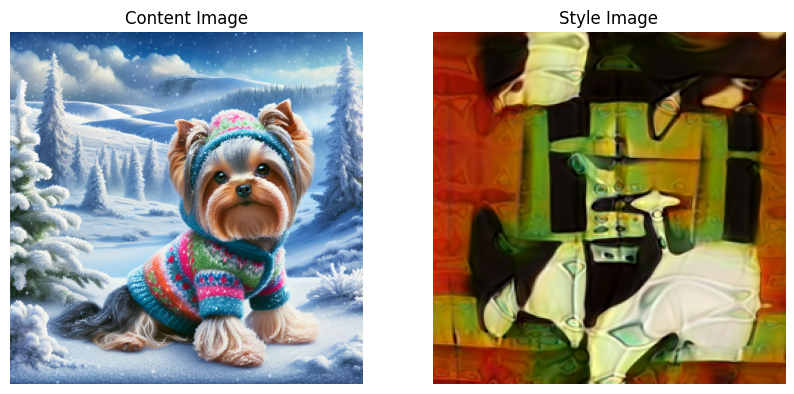

In [ ]:
plt.figure(figsize=(10, 5))

# Display the content image
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(content_image))
plt.title('Content Image')
plt.axis('off')

# Display the style image
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(style_image))
plt.title('Style Image')
plt.axis('off')

plt.show()

In [ ]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

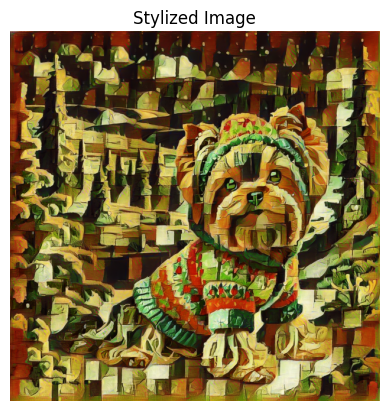

In [ ]:
plt.imshow(np.squeeze(stylized_image))
plt.title('Stylized Image')
plt.axis('off')
plt.show()

In [ ]:
# Directory where images are saved
directory = '/content/drive/MyDrive/GANsNFTs/stylized_images'

In [ ]:
def get_next_filename(directory, base_filename="image", extension=".jpg"):
    i = 0
    # Loop to find the first available filename that does not exist
    while True:
        new_filename = f"{base_filename}_{i}{extension}"
        if not os.path.exists(os.path.join(directory, new_filename)):
            return new_filename
        i += 1

In [ ]:
# Assuming 'stylized_image' is a TensorFlow tensor output from the NST model
# Convert to numpy array
stylized_image_np = stylized_image.numpy()

# Check if the image needs to be rescaled
if np.max(stylized_image_np) <= 1.0:
    # Assuming the image is scaled between 0 and 1, scale to 0-255
    stylized_image_np = (stylized_image_np * 255).astype(np.uint8)

# Check if the image is in the correct format (Height x Width x Channels)
# If the image tensor is in a different format, adjust dimensions accordingly
if len(stylized_image_np.shape) == 4:
    # Remove the batch dimension if present
    stylized_image_np = stylized_image_np[0]

# Get the next available filename
new_filename = get_next_filename(directory)
stylized_image_bgr = cv2.cvtColor(stylized_image_np, cv2.COLOR_RGB2BGR)
# Use OpenCV to write the image file
cv2.imwrite(os.path.join(directory, new_filename), stylized_image_bgr)

True

# NFT

## Upload to IPFS

In [3]:
import requests
from pinata import Pinata
from google.colab import userdata

In [ ]:
pinata = Pinata(api_key=userdata.get('pinata-api-key'),
                secret_key=userdata.get('pinata-secret-key'),
                access_token=userdata.get('pinata-JWT'))

In [7]:
# Pin a file using Pinata
file_path = '/content/drive/MyDrive/GANsNFTs/stylized_images/image_0.jpg'
response = pinata.pin_file(file_path)
print(response)

{'status': 'success', 'data': {'IpfsHash': 'QmbgWuC6FsKht7rg1vWhewJps9LrG5CwYCUZEbUqebeSWP', 'PinSize': 515492, 'Timestamp': '2024-06-01T09:29:45.633Z'}}


In [8]:
ipfs_hash = response['data']['IpfsHash']
print("IPFS Hash:", ipfs_hash)

IPFS Hash: QmbgWuC6FsKht7rg1vWhewJps9LrG5CwYCUZEbUqebeSWP


In [9]:
base_url = "https://bronze-worried-hornet-934.mypinata.cloud/ipfs/"
image_url = f"{base_url}{ipfs_hash}"
print("Image URL:", image_url)

Image URL: https://bronze-worried-hornet-934.mypinata.cloud/ipfs/QmbgWuC6FsKht7rg1vWhewJps9LrG5CwYCUZEbUqebeSWP


## Mint NFTs

In [10]:
import os
import json

# Setup environment variables and API key
api_key = userdata.get('crossming-api-key')
chain = "polygon-amoy"  # or other chains like "ethereum-sepolia"
env = "staging"  # or "www"
wallet_address = "0xA7E032b8BA9c558F16e464014d9dC3dc22634aDF"
recipient_address = f"{chain}:{wallet_address}"

In [11]:
url = f"https://{env}.crossmint.com/api/2022-06-09/collections/default/nfts"
headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "x-api-key": api_key,
}
payload = {
    "recipient": recipient_address,
    "metadata": {
        "name": "NFTRIO",
        "image": image_url,
        "description": "minted NFT for Rio",
    },
}

In [12]:
response = requests.post(url, headers=headers, json=payload)
response_data = response.json()
print(response_data)

{'id': '7a6d2d22-30da-4f89-b10b-7ffc9e53a7e7', 'onChain': {'status': 'pending', 'chain': 'polygon-amoy', 'contractAddress': '0x022CAF8da2c77350DA5dBc7Ae0b786EFf8eC5899'}, 'actionId': '7a6d2d22-30da-4f89-b10b-7ffc9e53a7e7'}


In [13]:
response = requests.post(url, headers=headers, json=payload)
response_data = response.json()
print(response_data)

{'id': 'b688bc2a-e014-465b-8e72-a463858c3694', 'onChain': {'status': 'pending', 'chain': 'polygon-amoy', 'contractAddress': '0x022CAF8da2c77350DA5dBc7Ae0b786EFf8eC5899'}, 'actionId': 'b688bc2a-e014-465b-8e72-a463858c3694'}
